In [1]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

import os
import torch

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel, count_parameters
import datetime

assert torch.cuda.is_available()

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [2]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 80
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
MODEL_PATH = os.environ['MODELS_PATH']
RESNET_DECODE_MODEL = os.path.join(MODEL_PATH, 'mlp2489100.pt')

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [3]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [6],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 1


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 8587])
6


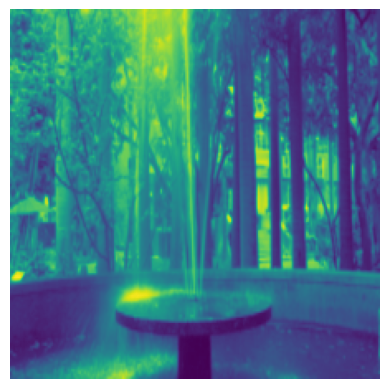

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [4]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 

extractor = ResnetExtractor()


In [5]:
readin = ReadIn(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

params = count_parameters(readin)
print("Total parametrs: ", params)


Total parametrs:  220345344


In [ ]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)


losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



  0%|                                                                                        | 0/71 [00:00<?, ?it/s]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|█▏                                                                              | 1/71 [00:03<03:31,  3.02s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


  3%|██▎                                                                             | 2/71 [00:04<02:24,  2.09s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


  4%|███▍                                                                            | 3/71 [00:05<02:02,  1.80s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


  6%|████▌                                                                           | 4/71 [00:07<01:50,  1.66s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


  7%|█████▋                                                                          | 5/71 [00:08<01:48,  1.64s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


  8%|██████▊                                                                         | 6/71 [00:10<01:40,  1.55s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 10%|███████▉                                                                        | 7/71 [00:11<01:35,  1.49s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 11%|█████████                                                                       | 8/71 [00:13<01:38,  1.56s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 13%|██████████▏                                                                     | 9/71 [00:14<01:32,  1.49s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 14%|███████████▏                                                                   | 10/71 [00:16<01:31,  1.49s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 15%|████████████▏                                                                  | 11/71 [00:17<01:24,  1.41s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 17%|█████████████▎                                                                 | 12/71 [00:18<01:25,  1.44s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 18%|██████████████▍                                                                | 13/71 [00:20<01:21,  1.41s/it]

torch.Size([64, 1, 224, 224])
Range of valuse in stim:  tensor(0., device='cuda:0') tensor(1., device='cuda:0')


 20%|███████████████▌                                                               | 14/71 [00:22<01:31,  1.60s/it]


KeyboardInterrupt: 

Text(0.5, 0, 'Batch')

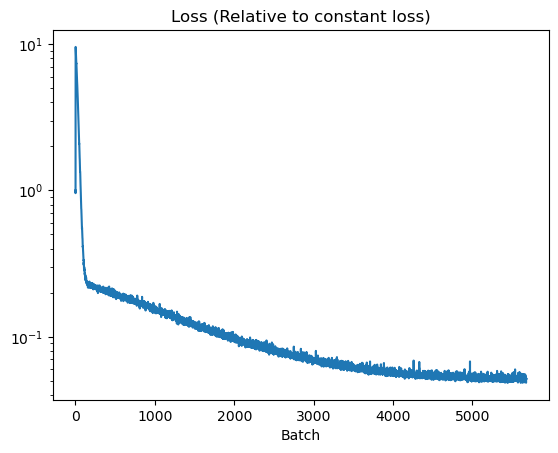

In [ ]:
# Plot losses
plt.plot(losses)
plt.yscale('log')

plt.title('Loss (Relative to constant loss)')
plt.xlabel('Batch')

In [20]:
readin_models_path = os.path.join(MODEL_PATH, "readin")
if not os.path.exists(readin_models_path):
    os.makedirs(readin_models_path)

# Switch based on whether you want to save the model
if False: # Save the model
# if False: # Load last model
    # Save the model
    model_path = os.path.join(readin_models_path, f"readin_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pt")
    print(f"Saving model to {model_path}")
    torch.save(readin,model_path)
else:

    model_path = os.path.join(readin_models_path, os.listdir(readin_models_path)[-1])
    readin = torch.load(model_path)
    print(f"Loaded model from {model_path}")

Loaded model from /scratch/izar/vanousek/cs-433-project/models/readin/2024-12-16 16:22:20.529968.pt


In [21]:
# Evaluate the model
readin.eval()
test_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x8587 and 9395x25088)

In [10]:

output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, recon, pred in zip(imgs, imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = real
        print(real_img.shape)
        for i in range(real_img.shape[0]):
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()